In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

# Задание 1. 
## Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). Функция должна быть написана на python. В ходе решения можно тестировать работу функции как на полном датасете, так и на части (сэмпле) данных. 

## Шаг 1 - подготавливаем данные.

In [65]:
df_activ = pd.read_csv('problem1-auth_data.csv',sep=';')
# считываем данные о активности пользователей

In [66]:
df_reg = pd.read_csv('problem1-reg_data.csv', sep=';')
# считываем данные о регистрации пользователей

In [67]:
df_activ.head()

,auth_ts,uid
0,911382223,1.0
1,932683089,2.0
2,932921206,2.0
3,933393015,2.0
4,933875379,2.0


In [68]:
df_activ.isna().sum()
# проверяем наличие пропущенных значений

auth_ts    0
uid        1
dtype: int64

In [69]:
df_activ = df_activ.dropna()
#  удаляем строки с пропущенными значениями

In [70]:
df_activ.isna().sum()
#  првоеряем, все ок


auth_ts    0
uid        0
dtype: int64

In [71]:
df_activ['uid'] = df_activ['uid'].astype(int)
# переводим колонку в целочисленный формат

In [72]:
df_activ.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [73]:
df_activ['auth_ts'] = pd.to_datetime(df_activ['auth_ts'], unit = 's')
df_activ = df_activ.rename(columns ={'auth_ts': 'date_activity'})
#  переводим колонку с секундами в формат даты и далее сразу переименовываем ее

In [74]:
df_activ.head()

,date_activity,uid
0,1998-11-18 09:43:43,1
1,1999-07-22 22:38:09,2
2,1999-07-25 16:46:46,2
3,1999-07-31 03:50:15,2
4,1999-08-05 17:49:39,2


In [75]:
df_reg.isna().sum()
# проверяем наличие пропущенных значений , в этом дата фрейме их нет, отлично.

reg_ts    0
uid       0
dtype: int64

In [76]:
df_reg['reg_ts'] = pd.to_datetime(df_reg['reg_ts'], unit = 's')
df_reg = df_reg.rename(columns ={'reg_ts': 'date_registr'})
# также переводим колонку с секундами в даты и сразу переименовываем

In [77]:
df_reg.head()

,date_registr,uid
0,1998-11-18 09:43:43,1
1,1999-07-22 22:38:09,2
2,2000-01-13 22:27:27,3
3,2000-05-28 14:19:01,4
4,2000-09-16 11:21:53,5


In [78]:
df_full = pd.merge(df_activ, df_reg, how = 'left')
# объединяем два дата фрейма в один по колонке uid 

In [79]:
df_full.head()

,date_activity,uid,date_registr
0,1998-11-18 09:43:43,1,1998-11-18 09:43:43
1,1999-07-22 22:38:09,2,1999-07-22 22:38:09
2,1999-07-25 16:46:46,2,1999-07-22 22:38:09
3,1999-07-31 03:50:15,2,1999-07-22 22:38:09
4,1999-08-05 17:49:39,2,1999-07-22 22:38:09


## Подготовили данные для подсчета Retention. Обработку данных решил не включать в функцию, чтобы подавать ей уже подготовленную таблицу. (т.к. в реальности мы незнаем какие данные будем получать, и для начала их нужно предобработать)
## Retention будем считать с помощью когортного анализа. У нас игра, возьмем период месяц (считаем, что если пользователю интересна данная игра, то он будет заходить минимум раз в месяц) и будем считать месчный Retention.

## Шаг 2 - подсчет Retention.

In [80]:
def calculate_cohort_retention(df_full):
    # Присваиваем когорты на основе даты регистрации и активности для каждого пользователя
    df_full['registr_month'] = df_full['date_registr'].dt.to_period('M')
    df_full['activity_month'] = df_full['date_activity'].dt.to_period('M')
    
    # Рассчитываем номер периода в днях (месяц, делим на 30)
    df_full['period_number_month'] = ((df_full.date_activity - df_full.date_registr).dt.days // 30)
    
    
     # Агрегируем данные по когортам и рассчитанному номеру периода (в месяцах) и считаем уникальное количество пользователей 
    cohort_data = df_full.groupby(['registr_month', 'period_number_month']).agg(users=('uid', 'nunique')).reset_index()
   
    
    # Создаем сводную таблицу для когортного анализа
    cohort_pivot = cohort_data.pivot_table(index='registr_month', columns='period_number_month', values='users')
    # Сохраняем размер когорты
    cohort_size = cohort_pivot.iloc[:, 0]
    
    # Делаем ретеншен матрицу. Результат умножаем на 100, т.к. ретеншен измеряется в процентах
    retention_matrix = (cohort_pivot.divide(cohort_size, axis = 0) * 100).round(1)
    
    return retention_matrix, cohort_pivot

# Сохраняем в переменную 
cohort_retention = calculate_cohort_retention(df_full)

### Для удобства в самой функции мы сохранили в переменную таблицу с процентным Retention, а также таблицу с количеством пользователей, чтобы иметь возможность анализировать две таблицы.

In [81]:
cohort_retention[1].loc['2017',:18]
# вызываем функцию и смотрим на когорты (количество пользователей) 2017г. С помощью фильтра loc можно выбрать любой период.

period_number_month,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
registr_month,,,,,,,,,,,,,,,,,,,
2017-01,5573.0,596.0,284.0,284.0,284.0,284.0,284.0,284.0,284.0,284.0,284.0,284.0,284.0,284.0,284.0,284.0,284.0,284.0,284.0
2017-02,5284.0,572.0,271.0,271.0,271.0,271.0,271.0,271.0,271.0,271.0,271.0,271.0,271.0,271.0,271.0,271.0,271.0,271.0,271.0
2017-03,6141.0,620.0,312.0,312.0,312.0,312.0,312.0,312.0,312.0,312.0,312.0,312.0,312.0,312.0,312.0,312.0,312.0,312.0,312.0
2017-04,6248.0,702.0,327.0,327.0,327.0,327.0,327.0,327.0,327.0,327.0,327.0,327.0,327.0,327.0,327.0,327.0,327.0,327.0,327.0
2017-05,6788.0,717.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0
2017-06,6908.0,748.0,372.0,372.0,372.0,372.0,372.0,372.0,372.0,372.0,372.0,372.0,372.0,372.0,372.0,372.0,372.0,372.0,372.0
2017-07,7505.0,756.0,372.0,372.0,372.0,372.0,372.0,372.0,372.0,372.0,372.0,372.0,372.0,372.0,372.0,372.0,372.0,372.0,372.0
2017-08,7897.0,815.0,401.0,401.0,401.0,401.0,401.0,401.0,401.0,401.0,401.0,401.0,401.0,401.0,401.0,401.0,401.0,401.0,401.0
2017-09,8035.0,855.0,390.0,390.0,390.0,390.0,390.0,390.0,390.0,390.0,390.0,390.0,390.0,390.0,390.0,390.0,390.0,390.0,390.0


In [82]:
cohort_retention[0].loc['2017', :18]
#смотрим на те же самые данные, но уже в процентном отношении. С помощью фильтра loc можно выбрать любой период.

period_number_month,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
registr_month,,,,,,,,,,,,,,,,,,,
2017-01,100.0,10.7,5.1,5.1,5.1,5.1,5.1,5.1,5.1,5.1,5.1,5.1,5.1,5.1,5.1,5.1,5.1,5.1,5.1
2017-02,100.0,10.8,5.1,5.1,5.1,5.1,5.1,5.1,5.1,5.1,5.1,5.1,5.1,5.1,5.1,5.1,5.1,5.1,5.1
2017-03,100.0,10.1,5.1,5.1,5.1,5.1,5.1,5.1,5.1,5.1,5.1,5.1,5.1,5.1,5.1,5.1,5.1,5.1,5.1
2017-04,100.0,11.2,5.2,5.2,5.2,5.2,5.2,5.2,5.2,5.2,5.2,5.2,5.2,5.2,5.2,5.2,5.2,5.2,5.2
2017-05,100.0,10.6,5.4,5.4,5.4,5.4,5.4,5.4,5.4,5.4,5.4,5.4,5.4,5.4,5.4,5.4,5.4,5.4,5.4
2017-06,100.0,10.8,5.4,5.4,5.4,5.4,5.4,5.4,5.4,5.4,5.4,5.4,5.4,5.4,5.4,5.4,5.4,5.4,5.4
2017-07,100.0,10.1,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
2017-08,100.0,10.3,5.1,5.1,5.1,5.1,5.1,5.1,5.1,5.1,5.1,5.1,5.1,5.1,5.1,5.1,5.1,5.1,5.1
2017-09,100.0,10.6,4.9,4.9,4.9,4.9,4.9,4.9,4.9,4.9,4.9,4.9,4.9,4.9,4.9,4.9,4.9,4.9,4.9


### В дополнение создадим функцию для построения тепловой карты месячного Retention. 

In [83]:
# # Построение тепловой карты
# в фильтре можно отобрать нужные данные. Также можно не включать первый столбец, чтобы была наглядная разница. 
# Мы взяли данные за последние 3 года и не включили нулевой период.

def grafic_retention_matrix(cohort_retention):
    plt.figure(figsize=(16, 11))
    sns.heatmap(cohort_retention.iloc[190:, 1:25], annot=True, cmap='Reds', cbar=True, fmt=".1f" )
    plt.title('Monthly Retention ', fontsize=16)
    plt.xlabel('Months', fontsize=14)
    plt.ylabel('Cohorts', fontsize = 14)
    plt.show()
    
    


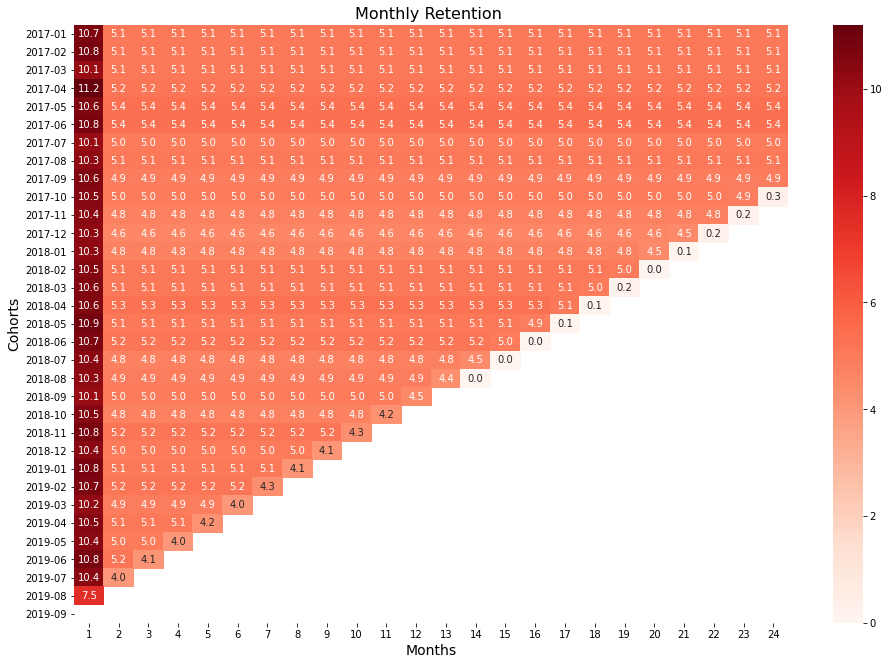

In [86]:
grafic_retention_matrix(cohort_retention[0])
# месячный Retention на тепловой карте.

## Вывод. Сделали когортный анализ и посчитали месячный Retention. Данные сохранены за очень долгий период, удобнее конечно пользоваться фильтрацией для наглядности. В целом видим, что месячный Retention всегда на уровне 5% начиная с 2010г. Основной поток пользователей пошел с 2015г, но уровень Retention оставался на одном и том же уровне почти всегда.

# Задание 2.
## Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

## Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [4]:
df_ab = pd.read_csv('Проект_1_Задание_2.csv', sep=';')
# считываем данные, сохраняем в переменную.

In [5]:
df_ab.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [4]:
df_ab.groupby('testgroup')['user_id'].nunique().reset_index()
# группируем данные по группе пользователей и смотрим на общее количество

,testgroup,user_id
0,a,202103
1,b,202667


In [6]:
df_arpu = df_ab.groupby('testgroup').agg({'user_id':'nunique','revenue': 'mean'}).round(2).reset_index()
# считаем метрику ARPU среднюю выручку на пользователя

In [7]:
df_arpu

,testgroup,user_id,revenue
0,a,202103,25.41
1,b,202667,26.75


In [8]:
df_arppu = df_ab.query('revenue > 0').groupby('testgroup').agg({'user_id':'nunique','revenue': 'mean'}).round(2).reset_index()
# считаем метрику ARPPU - среднюю выручку на платящего пользователя

In [9]:
df_arppu

,testgroup,user_id,revenue
0,a,1928,2664.00
1,b,1805,3003.66


In [10]:
df_all =  pd.merge(df_arpu, df_arppu, on = "testgroup")
df_all.head()

,testgroup,user_id_x,revenue_x,user_id_y,revenue_y
0,a,202103,25.41,1928,2664.00
1,b,202667,26.75,1805,3003.66


In [11]:
df_all['CR'] = df_all.user_id_y / df_all.user_id_x
# добавили колонку с конверсией

In [12]:
df_all

,testgroup,user_id_x,revenue_x,user_id_y,revenue_y,CR
0,a,202103,25.41,1928,2664.00,0.009540
1,b,202667,26.75,1805,3003.66,0.008906


##  У нас имеются данные после результата А/Б теста. Мы посмотрели на три метрики, ARPU(средняя выручка на пользователя), ARPPU(средняя выручка на платящего пользователя) и  CR(конверсия в покупку).  Их далее и будем анализировать для принятия решения по А/Б тесту.  Далее нам необходимо продолжить изучать данные, проверить их на нормальность, наличие выбросов (аномальных значений)  и после этого уже сравнивать с помощью статистических методов. 

In [13]:
import scipy.stats as st
import pingouin as pg

/opt/conda/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


## Начинаем анализ метрики ARPU.

In [14]:
control_arpu = df_ab.query("testgroup == 'a'").revenue
test_arpu = df_ab.query("testgroup == 'b' ").revenue
# присваиваем каждой группе нужную переменную. Метрика ARPU

In [15]:
st.normaltest(control_arpu)
# проверяем данные на нормальность с использованием теста Агостино-Пирсона, т.к. выборка большая, больше 5000.
# Н0 - данные распределены нормально
# Н1 - данные распределены не нормально

NormaltestResult(statistic=585152.7312728433, pvalue=0.0)

In [16]:
st.normaltest(test_arpu)
# проверяем данные на нормальность с использованием теста Агостино-Пирсона, т.к. выборка большая, больше 5000.
# Н0 - данные распределены нормально
# Н1 - данные распределены не нормально

NormaltestResult(statistic=326622.39540856465, pvalue=0.0)

In [17]:
# Видим по тестам, что данные не имеют нормальное распределение. Хотя для больших выборок это не критично, но на всякий случай решили првоерить.
# Далее построим Бокс плот и гистограмму чтобы изучить данные на предмет аномальных значений или выбросов.

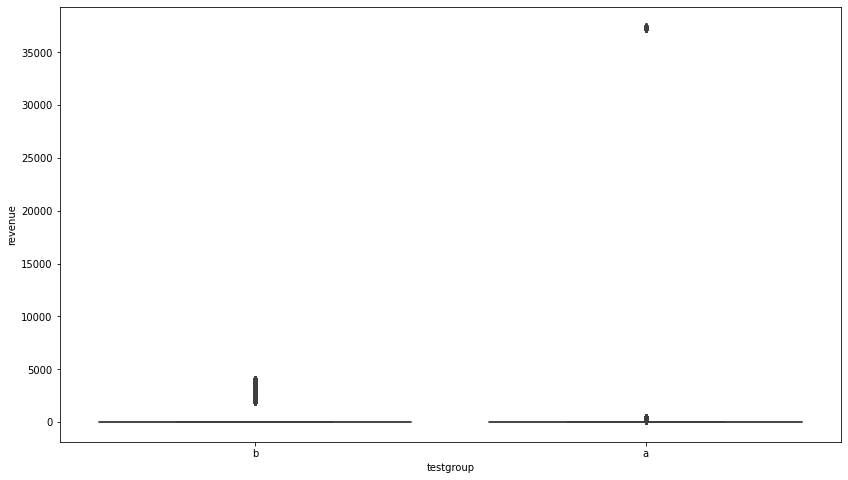

In [18]:
# Строим Box-plot. Видим, что в контрольной группе(А) вроде прослеживаются аномальные значения, есть выбросы в данных.
plt.figure(figsize = (14,8))
sns.boxplot(x="testgroup", y="revenue", data=df_ab)


### Чтобы увидеть более детально аномальные значения, возьмем только платящих пользователей и смотрим на их выручку.

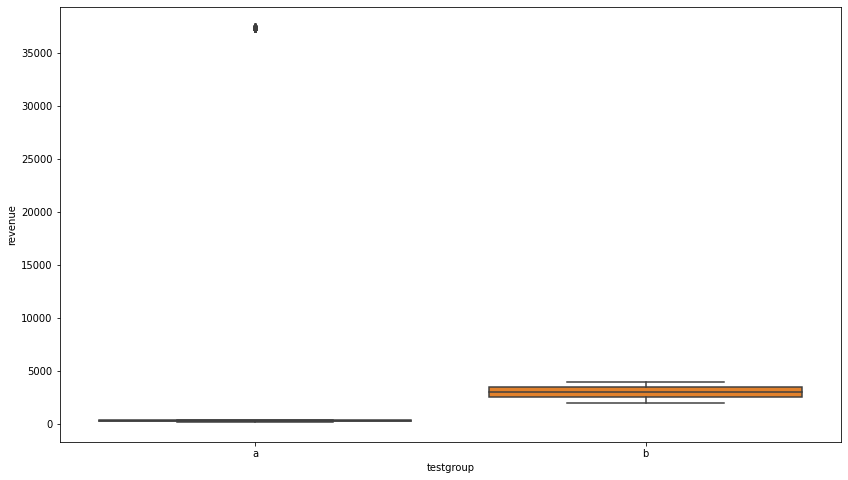

In [19]:
# Строим еще один Бокс плот.
plt.figure(figsize = (14,8))
sns.boxplot(x="testgroup", y="revenue", data=df_ab.query(" revenue > 0"))
plt.show()

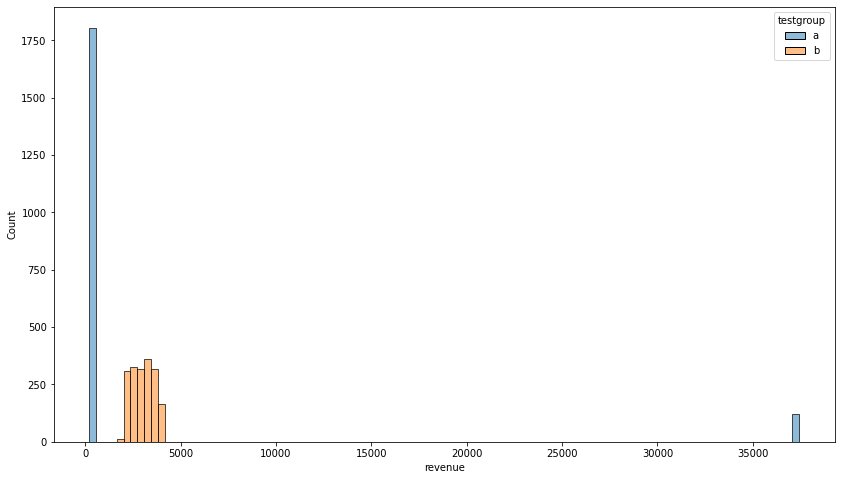

In [20]:
# Для полной уверенности строим еще гистограмму также только по платящим пользователям.  
plt.figure(figsize = (14,8))
sns.histplot(x="revenue", hue="testgroup", data= df_ab.query(" revenue > 0"))
plt.show()

In [21]:
df_ab.groupby('testgroup').agg({'revenue' : 'max'}).reset_index()
# Увидели максимальные значения в обеих группах. 

,testgroup,revenue
0,a,37433
1,b,4000


In [22]:
# Видим, что аномальные значения есть у 123 пользователей, все они принадлежат группе А, И все значения около 37300руб. 
df_ab.query(" revenue > 5000 ")

,user_id,revenue,testgroup
416,417,37324,a
4428,4429,37304,a
5777,5778,37315,a
8065,8066,37307,a
8743,8744,37334,a
...,...,...,...
360696,360697,37347,a
378668,378669,37297,a
389341,389342,37298,a
394580,394581,37302,a


In [23]:
df_ab.query(" revenue > 5000 ").revenue.sum()

4590252

In [24]:
df_ab.query("testgroup == 'a' ").revenue.sum()

5136189

In [30]:
df_ab.query(" revenue > 5000 ").revenue.sum() / df_ab.query("testgroup == 'a' ").revenue.sum()

0.8937077665950377

## Из построенных графиков и таблиц вы видим, что в контрольной группе А есть аномальные значения. После более детального анализа данных, мы выяснили, что эти значения только у 123 пользователей , и они все приблизительно равны 37300р. Мы видим, что данные не разбросаны, а кучно сгруппированны около одной цифры, можем сделать предположение, что пользователи выбрали дорогие акционные предложения. В теории возможно что это и ошибочные данные, но мы также видим что сумма выручки от аномальных значений составляет 89% от всей выручки группы А, поэтому если мы удалим эти данные, то группа А заведомо проиграет по метрикам ARPU и ARPPU. Поэтому принимаем решение что данные мы не будем удалять, будем проводить статистический анализ с ними. 

## Приступаем к сравнению метрики ARPU

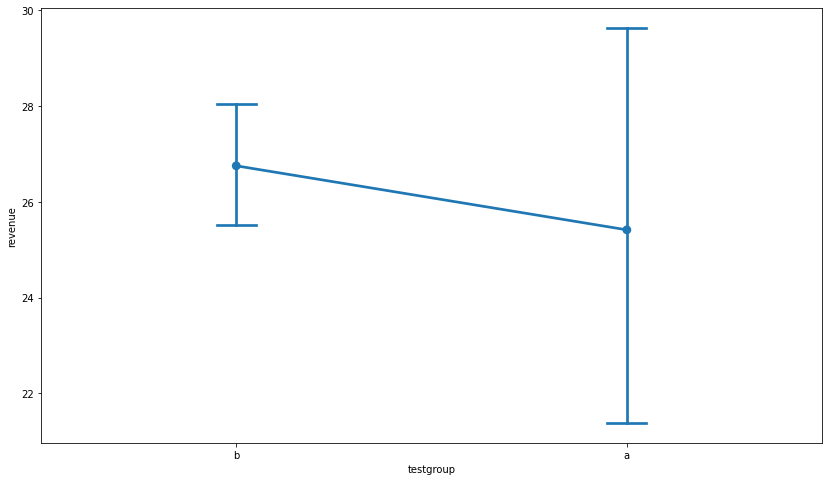

In [25]:
plt.figure(figsize = (14,8))
sns.pointplot(x="testgroup", #название группирующей переменной
              y="revenue", #название переменной, которую мы сравниваем
              data=df_ab, #датафрейм с данными
              capsize=0.1)
plt.show()
# для визуализации еще построим график - ящик с усами. Мы наглядно видим, что доверительный интервал в группе А больше(засчет аномальных значений) более широкий

In [ ]:
#перед проведение Т-теста проверим данные на равенство дисперсий.
# Но - дисперсии не различаются
# Н1 - дисперсии различаются

In [26]:
st.levene(control_arpu, test_arpu)
# Видим, что pvalue > 0.05 , это означает что принимаем Но - дисперсии не различаются.
# Это лзначает что будем проводить классический Т-тест 

LeveneResult(statistic=0.3896289474701388, pvalue=0.5324948591043842)

In [41]:
# Делаем Т-тест.
# Н0 - ARPU не различаются в группах А и В
# Н1 - ARPU различаются в группах А и В

In [27]:
st.ttest_ind(control_arpu, test_arpu)
# Делаем Т-тест.
# Видим, что pvalue > 0.05, это означает что Н0 не отвергается - ARPU статистически значимо НЕ различаются.

Ttest_indResult(statistic=-0.6242026493616787, pvalue=0.532494858971837)

## По визуализации и самому Т тесту видим что нет статистически значимого различия, ARPU в группах не различаются.


  
# Далее приступаем к метрике ARPPU , ее будем сравнивать тоже  методом Т-теста.

In [28]:
control_arppu = df_ab.query("testgroup == 'a' and revenue > 0 ").revenue
test_arppu = df_ab.query("testgroup == 'b' and revenue > 0 ").revenue
# присваиваем каждой группе нужную переменную. Метрика ARPPU

In [29]:
st.shapiro(control_arppu)
# проверяем данные на нормальность с использованием теста Шапиро-Уилка, т.к. выборка до 5000.
# Н0 - данные распределены нормально
# Н1 - данные распределены НЕ нормально

ShapiroResult(statistic=0.2667924761772156, pvalue=0.0)

In [30]:
st.shapiro(test_arppu)
# проверяем данные на нормальность с использованием теста Шапиро-Уилка, т.к. выборка до 5000.
# Н0 - данные распределены нормально
# Н1 - данные распределены НЕ нормально

ShapiroResult(statistic=0.9583123922348022, pvalue=2.491345674771425e-22)

## Видим, что данные распределены не неормально в обоих группах. 

In [ ]:
#перед проведением Т-теста проверим данные на равенство дисперсий.
# Н0 - дисперсии не различаются
# Н1 - дисперсии различаются

In [31]:
st.levene(control_arppu, test_arppu)
# Видим, что pvalue < 0.05 , это означает что принимаем Н1 - дисперсии различаются.
# Это лзначает что будем проводить  Т-тест Уэлча с поправкой не неравные дисперсии.

LeveneResult(statistic=80.85567421779912, pvalue=3.779689868667878e-19)

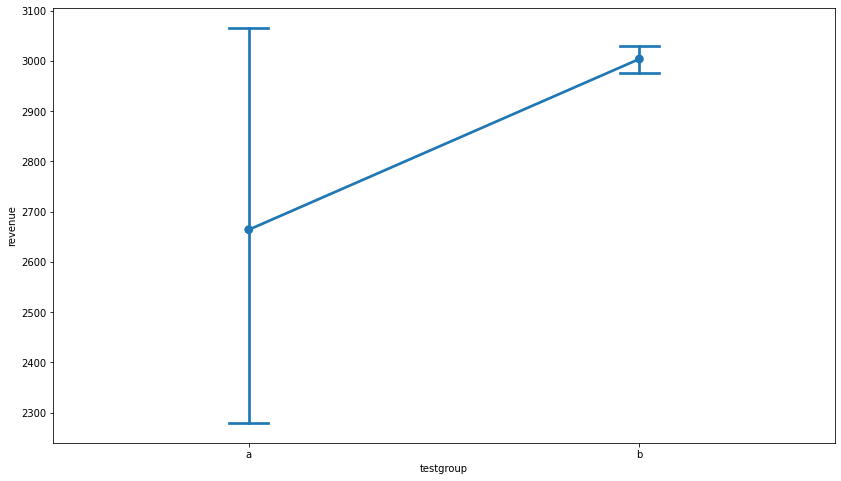

In [49]:
plt.figure(figsize = (14,8))
sns.pointplot(x="testgroup", #название группирующей переменной
              y="revenue", #название переменной, которую мы сравниваем
              data=df_ab.query("0 < revenue "), #датафрейм с данными
              capsize=0.1)
plt.show()
# для визуализации еще построим график - ящик с усами. Мы наглядно видим, что доверительный интервал в группе А больше(засчет аномальных значений) более широкий

In [50]:
st.ttest_ind(control_arppu, test_arppu, equal_var = False)

Ttest_indResult(statistic=-1.6446302664300838, pvalue=0.10020780398916015)

### По визуализации и самому Т тесту видим что нет статистически значимых различий. ARPPU в группах не различается. Далее приступаем к анализу метрики CR. 
### Конверсия, это категориальная переменная (пользователь является платящим или нет), и здесь мы применим метод Хи квадрат. Сделаем таблицу сопряженности и проведем статистический тест. 

In [53]:
df_all
# выводим ранее созданный дф

,testgroup,user_id_x,revenue_x,user_id_y,revenue_y,CR
0,a,202103,25.41,1928,2664.00,0.009540
1,b,202667,26.75,1805,3003.66,0.008906


In [54]:
df_all["cr_now"] = df_all["user_id_x"] - df_all["user_id_y"]
# создаем колонку с количеством не платящих пользователей

In [57]:
df_cr = df_all[["cr_now","user_id_y"]]
# создаем отдельную таблицу сопряженности (платящий пользователь или нет)

In [58]:
df_cr = df_cr.rename(columns = {"user_id_y" : "cr_yes"})
# переименовываем колонку для наглядности

In [59]:
df_cr

,cr_now,cr_yes
0,200175,1928
1,200862,1805


In [ ]:
# H0 -  CR в контрольной и тестовой группах не различаются
# H1 -  CR в контрольной и тестовой группах различаются

In [61]:
st.chi2_contingency(df_cr)

(4.374729521260405,
 0.03647561892312613,
 1,
 array([[200239.10075104,   1863.89924896],
        [200797.89924896,   1869.10075104]]))

## По результатам теста Хи квадрат,видим, что pvalue - 0.0364, следовательно мы принимаем альтернативную гипотезу - CR в группах статистически различаются. И CR в контрольной группе А выше, чем в тестовой. 

## Вывод. 
## Мы провели анализ А/В теста, сравнили результаты по трем метрикам. ARPU и ARPPU статистически не различаются в контрольной и тестовых группах (хотя изначально так не казалось). CR показала статистичесое различие. Следовательно, необходимо выбирать акционные товары, которые показывались контрольной группе. 

### В реальности можно еще изучить аномальные выбросы подробнее. Если это реальные покупки, а не ошибочные данные, то тогда все оставляем как есть. А если понимаем, что это не покупки, а просто ошибочные данные, то в этом случае аномальные значения можно удалить и провести стат анализ еще раз.

# Задание 3.

## В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

## Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

## Метрики (вопрос 1) 
### Основные :
### 1. Какое количество пользователей участвовало в событии. (DAU/MAU)
### 2. Возврат пользователей в игру во время события. (Retention)
### 3. Средняя выручка с участника события. (ARPU)
### 4. Стоимость привлечения пользователя. (CPA)
### 5. Средняя выручка с пользователя, за всю его жизнь, активность. (LTV)

### Второстепенные :
### 1. Какое количество пользователей прошли все уровни и получили награду.
### 2. Какой процент пользователей ( от всех, кто принимал участие) прошел все уровни и получил награду.
### 3. Какое количество пользователей не дошли до награды.
### 4. Какой процент пользователей ( от всех, кто принимал участие) не дошел до награды.
### 5. Среднее время прохождения всех уровней до награды.
### 6. Какой уровень оказался самым долгим по времени прохождения.
### 7. Какой уровень оказался самым быстрым по времени прохождения.
### 8. Какой уровень оказался самым сложным ( на каком уровне чаще всего спотыкались игроки).
### 9. Какой уровень оказался самым легким (проходили с минимальным количеством ошибок).



### Также можно еще смотреть на некоторые перечисленные метрики в сравнении с прошлыми тематическими событиями в игре, чтобы понимать как прошло данное событие в сравнении с предыдущими. На некоторые метрики можно смотреть совместно на одном графике. 



## Метрики (вопрос 2). 
### Подойдут все метрики с первого варианта(только уже с учетом откатов), а дополнительно касаемого второго варианта: 
### 1. Корреляция между количеством откатов и вероятностью ухода.
### 2. Среднее количество откатов на пользователя.
### 3. Минимальное и максимальное количество откатов.
### 4. Процент пользователей, покинушвих событие после одного или нескольких откатов.

